In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis
In this notebook, I will build a SKLearn linear regression model to predict the Voyager Coin & coin prices using their respective return data and blockchain transaction detail.

In [2]:
# Importing VGX Coin data off of Coingecko (Available from 2017-07-30)
coin_price = pd.read_csv(
    Path("Coin_Data.csv")
)



coin_price.head()


,snapped_at,price,market_cap,total_volume
0,7/30/2017,0.042280,2900848.770,16525.59406
1,7/31/2017,0.039353,2700033.420,16889.51459
2,8/1/2017,0.040123,2752876.132,23723.20212
3,8/2/2017,0.040573,2783727.431,13405.73166
4,8/3/2017,0.039876,2735954.701,19997.47362


In [3]:
# Importing VYGF Stcok data off of Yahoo Finanace (Available from 2021-04-08)
stock_price = pd.read_csv(
    Path("Stock_Data.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
stock_price.tail()

,Open,High,Low,Close*,Adj Close**,Volume
Date,,,,,,
2021-04-08,23.38,25.64,23.38,25.50,25.50,"1,370,600"
2021-04-07,25.90,27.43,22.90,23.02,23.02,"2,402,900"
2021-04-06,29.50,30.20,26.49,27.43,27.43,"1,542,000"
2021-04-05,27.85,29.85,27.40,29.00,29.00,"1,322,200"
2021-04-01,26.26,27.88,26.15,27.39,27.39,"1,238,200"


In [4]:
# Formatting the DFs

coin_price = coin_price.rename(columns = {'snapped_at':'Date','price':'Close','total_volume':'Volume'})
coin_price['Return'] = coin_price['Close'].pct_change()*100
coin_price = coin_price.dropna()
coin_price = coin_price[['Date','Close','Volume','Return']]
coin_price['Date'] = pd.to_datetime(coin_price['Date'])
coin_price = coin_price.set_index('Date')
coin_price.tail()


,Close,Volume,Return
Date,,,
2021-10-30,3.051938,2.301751e+07,3.084294
2021-10-31,2.822278,1.148685e+07,-7.525075
2021-11-01,2.954710,7.186877e+06,4.692393
2021-11-02,2.733736,6.312411e+06,-7.478695
2021-11-03,2.690162,5.203703e+06,-1.593949


In [5]:
coin_price['Lagged Return'] = coin_price['Return'].shift()
coin_price = coin_price.dropna()
coin_price.head()

,Close,Volume,Return,Lagged Return
Date,,,,
2017-08-01,0.040123,23723.20212,1.957113,-6.922640
2017-08-02,0.040573,13405.73166,1.120694,1.957113
2017-08-03,0.039876,19997.47362,-1.716144,1.120694
2017-08-04,0.044082,19455.90155,10.545653,-1.716144
2017-08-05,0.064873,50014.42697,47.164568,10.545653


In [6]:
# Formatting the DFs

stock_price = stock_price.rename(columns = {'Close*':'Close'})
stock_price['Return'] = stock_price['Close'].pct_change()*100
stock_price = stock_price.dropna()
stock_price = stock_price[['Close','Volume','Return']]
stock_price.head()

,Close,Volume,Return
Date,,,
2021-10-29,15.45,"2,918,100",5.821918
2021-10-28,14.21,"4,277,100",-8.025890
2021-10-27,10.35,"2,580,100",-27.163969
2021-10-26,9.14,"898,500",-11.690821
2021-10-25,9.52,"778,000",4.157549


In [7]:
stock_price['Lagged Return'] = stock_price['Return'].shift()
stock_price = stock_price.dropna()
stock_price.head()

,Close,Volume,Return,Lagged Return
Date,,,,
2021-10-28,14.21,"4,277,100",-8.025890,5.821918
2021-10-27,10.35,"2,580,100",-27.163969,-8.025890
2021-10-26,9.14,"898,500",-11.690821,-27.163969
2021-10-25,9.52,"778,000",4.157549,-11.690821
2021-10-22,9.76,"829,400",2.521008,4.157549


In [8]:
#Create DataFrame that will be used to predict prices
predict_df = stock_price.merge(coin_price['Return'],on="Date",how="left")
predict_df = predict_df.rename(columns={"Return_x":"Stock Return","Return_y":"Coin Return"})
predict_df = predict_df.drop(['Close'],axis=1)
predict_df = predict_df.drop(['Volume'],axis=1)
predict_df.head()

,Stock Return,Lagged Return,Coin Return
Date,,,
2021-10-28,-8.025890,5.821918,4.642487
2021-10-27,-27.163969,-8.025890,-6.054528
2021-10-26,-11.690821,-27.163969,-0.861741
2021-10-25,4.157549,-11.690821,-3.594475
2021-10-22,2.521008,4.157549,-3.996880


In [9]:
predict_df = predict_df.rename(columns={'Lagged Return':'Stock Lagged Return'})
predict_df = predict_df.merge(coin_price['Lagged Return'],on='Date',how='left')
predict_df = predict_df.rename(columns={'Lagged Return':'Coin Lagged Return'})
predict_df.head()

,Stock Return,Stock Lagged Return,Coin Return,Coin Lagged Return
Date,,,,
2021-10-28,-8.025890,5.821918,4.642487,-6.054528
2021-10-27,-27.163969,-8.025890,-6.054528,-0.861741
2021-10-26,-11.690821,-27.163969,-0.861741,-3.594475
2021-10-25,4.157549,-11.690821,-3.594475,3.334063
2021-10-22,2.521008,4.157549,-3.996880,3.433621


In [10]:
# Find midpoint of the dataset
predict_df.count()

Stock Return           147
Stock Lagged Return    147
Coin Return            147
Coin Lagged Return     147
dtype: int64

In [11]:
predict_df.iloc[74]

Stock Return           1.478261
Stock Lagged Return    0.965759
Coin Return           -1.885702
Coin Lagged Return    -3.278347
Name: 2021-07-15 00:00:00, dtype: float64

### Returns

### Train Test Split

In [12]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
test = predict_df['2021-07-15':]
train = predict_df[:'2021-07-16']
print(train.count())
print(test.count())

Stock Return           74
Stock Lagged Return    74
Coin Return            74
Coin Lagged Return     74
dtype: int64
Stock Return           74
Stock Lagged Return    74
Coin Return            74
Coin Lagged Return     74
dtype: int64


<ipython-input-12-ad8135f2638a>:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test = predict_df['2021-07-15':]


In [13]:
# First we will use the coin return to predict the stock return
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
stock_x_train = train['Coin Lagged Return'].to_frame()
stock_x_test = test['Coin Lagged Return'].to_frame()
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
stock_y_train = train['Stock Return'].to_frame()
stock_y_test = test['Stock Return'].to_frame()

# Linear Regression Model

In [14]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
stock_model = LinearRegression()
stock_model.fit(stock_x_train, stock_y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [15]:
# Make a prediction of "y" values using just the test dataset
stock_predictions = stock_model.predict(stock_x_test)

In [16]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
stock_results = stock_y_test
stock_results['Predicted Stock Return'] = stock_predictions
stock_results.head()

,Stock Return,Predicted Stock Return
Date,,
2021-10-28,-8.025890,0.392023
2021-10-27,-27.163969,1.216847
2021-10-26,-11.690821,0.782778
2021-10-25,4.157549,1.883310
2021-10-22,2.521008,1.899124


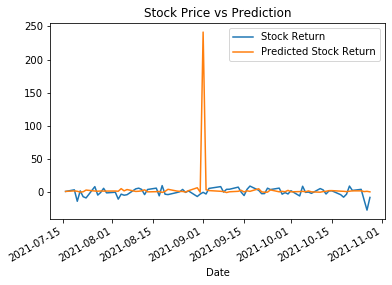

In [17]:
# Plot the predictions vs the true values
stock_results.plot(title="Stock Price vs Prediction")

In [18]:
stock_results.describe()

,Stock Return,Predicted Stock Return
count,74.000000,74.000000
mean,-0.201225,4.711376
std,6.120771,27.931044
min,-27.163969,-0.641137
25%,-3.192239,0.582491
50%,-0.108932,1.227329
75%,4.128800,1.895170
max,9.816850,241.472419


In [19]:
# Next we will use the stock return to predict the coin return
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
coin_x_train = train['Stock Lagged Return'].to_frame()
coin_x_test = test['Stock Lagged Return'].to_frame()
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
coin_y_train = train['Coin Return'].to_frame()
coin_y_test = test['Coin Return'].to_frame()

In [20]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
coin_model = LinearRegression()
coin_model.fit(coin_x_train, coin_y_train)

LinearRegression()

In [21]:
# Make a prediction of "y" values using just the test dataset
coin_predictions = coin_model.predict(coin_x_test)

In [22]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
coin_results = coin_y_test
coin_results['Predicted Coin Return'] = coin_predictions
coin_results.head()

,Coin Return,Predicted Coin Return
Date,,
2021-10-28,4.642487,0.946658
2021-10-27,-6.054528,-1.081885
2021-10-26,-0.861741,-3.885392
2021-10-25,-3.594475,-1.618755
2021-10-22,-3.996880,0.702848


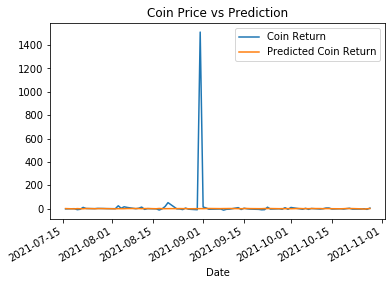

In [23]:
# Plot the predictions vs the true values
coin_results.plot(title="Coin Price vs Prediction")

In [24]:
coin_results.describe()

,Coin Return,Predicted Coin Return
count,74.000000,74.000000
mean,21.254128,0.073951
std,175.876011,0.902276
min,-12.558917,-3.885392
25%,-4.563707,-0.373811
50%,-0.881934,0.077858
75%,3.653727,0.703849
max,1511.697890,1.531870


# Analyze the On-Chain Data

In [25]:
# Read in Etherscan Data
etherscan_data = pd.read_csv(
    Path("Etherscan_Data.csv"))
etherscan_data.head()


,Txhash,Blockno,UnixTimestamp,DateTime,From,To,Quantity,Method
0,0x7086efbb4cd0578cbdff00c8df92af7387f36fb24fe8...,12916917,1627509736,7/28/2021,0x0000000000000000000000000000000000000000,0xe793e8aefc1e8f104a9be9cf73e4ab1dff892372,4.000000e+07,Exec Transaction
1,0x2b7618c0e2fc61b3e54031c58cfaf360e99801105570...,12921228,1627568960,7/29/2021,0x0000000000000000000000000000000000000000,0x9a4332ab6eac5833da6bff240c5d63faebc428e1,3.060147e+01,Swap
2,0x3fe4ab5dc6ac07c5e3b69957b5ac08c3b8dc0d917299...,12921318,1627570182,7/29/2021,0x0000000000000000000000000000000000000000,0x9a4332ab6eac5833da6bff240c5d63faebc428e1,5.000000e+00,Swap
3,0xe8407a943501ac3b0982738c976b2933d048d0fbe5d1...,12921433,1627571777,7/29/2021,0x9a4332ab6eac5833da6bff240c5d63faebc428e1,0x8692e782ea478623f3342e0fb3936f6530c5d54f,3.560140e+01,Stake
4,0xef551448e39fe347abb576f8ce44661b7e47c7770a67...,12921453,1627572005,7/29/2021,0x0000000000000000000000000000000000000000,0x9a4332ab6eac5833da6bff240c5d63faebc428e1,6.778987e+00,Swap


In [26]:
# Add a column for number of transactions daily; format date
etherscan_data = etherscan_data.rename(columns={'DateTime':'Date'})
etherscan_data['Transactions'] = 1
etherscan_data['Date'] = pd.to_datetime(etherscan_data['Date'])

In [27]:
# Because the quantity is showing in such a large number, we will show in 1000s

etherscan_data['Quantity'] = etherscan_data['Quantity']/1000

In [28]:
# Rearrange Data Frame by transactions & quantity of tokens traded by date
etherscan_data_transactions = etherscan_data.groupby(['Date']).sum()
etherscan_data_transactions = etherscan_data_transactions.drop(['Blockno'],axis=1)
etherscan_data_transactions = etherscan_data_transactions.drop(['UnixTimestamp'],axis=1)
etherscan_data_transactions.head()

,Quantity,Transactions
Date,,
2021-07-28,40000.000000,1
2021-07-29,100.252281,20
2021-07-30,877.648200,24
2021-07-31,561.334057,59
2021-08-01,6711.006166,283


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002BAC198A850>,
      dtype=object)

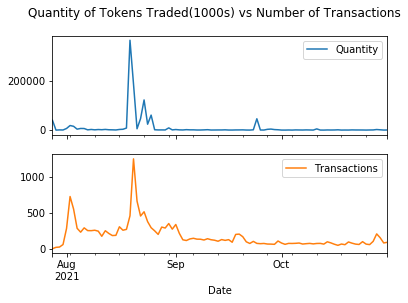

In [29]:
# Plot comparison between quantity of tokens moved vs transactions occured

etherscan_data_transactions.plot(subplots=True, title="Quantity of Tokens Traded(1000s) vs Number of Transactions")

In [30]:
# Orgainze data by quantity & transactions by Sender

etherscan_data_senders = etherscan_data.groupby(['From']).sum()
etherscan_data_senders.head()

,Blockno,UnixTimestamp,Quantity,Transactions
From,,,,
0x0000000000000000000000000000000000000000,70444205751,8800785302818,280539.068853,5402
0x0000000000007f150bd6f54c40a34d7c3d5e9f56,104614295,13037262823,2.051440,8
0x000000000035b5e5ad9019092c665357240f594e,117437886,14663543385,14.152875,9
0x00000000003b3cc22af3ae1eac0440bcee416b40,563690629,70093851237,31.818729,43
0x000000005736775feb0c8568e7dee77222a26880,91781477,11410863372,4.745805,7


In [31]:
# Drop unused data

etherscan_data_senders = etherscan_data_senders.sort_values(by = 'Quantity',ascending=False)
etherscan_data_senders = etherscan_data_senders.drop('Transactions',axis=1)
etherscan_data_senders = etherscan_data_senders.drop('Blockno',axis=1)
etherscan_data_senders = etherscan_data_senders.drop('UnixTimestamp',axis=1)
etherscan_data_senders.head()

,Quantity
From,
0x3f31dbdc099761156244a5bd5e06cdadbd2f30c0,286058.699640
0x0000000000000000000000000000000000000000,280539.068853
0xb32b48a1b1d5a353d49560a3767314fd513a1596,177570.582000
0x28c6c06298d514db089934071355e5743bf21d60,157723.065751
0xe793e8aefc1e8f104a9be9cf73e4ab1dff892372,38000.000000


In [32]:
# Find out what percent of tokens sent came from each address
quantity_sum = etherscan_data_senders['Quantity'].sum()
transactions_sum = etherscan_data_senders['Quantity'].sum()
etherscan_data_senders['Quantity %'] = (etherscan_data_senders['Quantity']/quantity_sum)*100

In [33]:
# See the sum of the top 5

etherscan_data_senders.head(5).sum()

Quantity      939891.416244
Quantity %        89.013177
dtype: float64

In [34]:
# See the sum of the rest of the population
etherscan_data_senders_rest = etherscan_data_senders[5:]
etherscan_data_senders_rest.sum()


Quantity      116010.020237
Quantity %        10.986823
dtype: float64

In [35]:
# Create a dataframe for the rest of the population and for the top 5 senders

rest_data = {'From':['All_Others'],'Quantity':[etherscan_data_senders_rest['Quantity'].sum()],'Quantity %':[etherscan_data_senders_rest['Quantity %'].sum()]}
rest_df = pd.DataFrame(rest_data)
etherscan_data_senders = etherscan_data_senders[:5]


In [36]:
# Adjust index of the rest_df to append to the top 5 senders
rest_df = rest_df.set_index('From')
rest_df.head()

,Quantity,Quantity %
From,,
All_Others,116010.020237,10.986823


In [37]:
# Append Dfs
etherscan_data_senders = etherscan_data_senders.append(rest_df,ignore_index=False)

In [38]:
# Reset the index for renaming purposes
etherscan_data_senders = etherscan_data_senders.reset_index()

In [39]:
# Rename the index by the last 5 characters of the wallet addresses

etherscan_data_senders = etherscan_data_senders.rename(index={0:'f30c0',1:'00000',2:'a1596',3:'21d60',4:'92372',5:'All_Others'}).drop('From',axis=1)

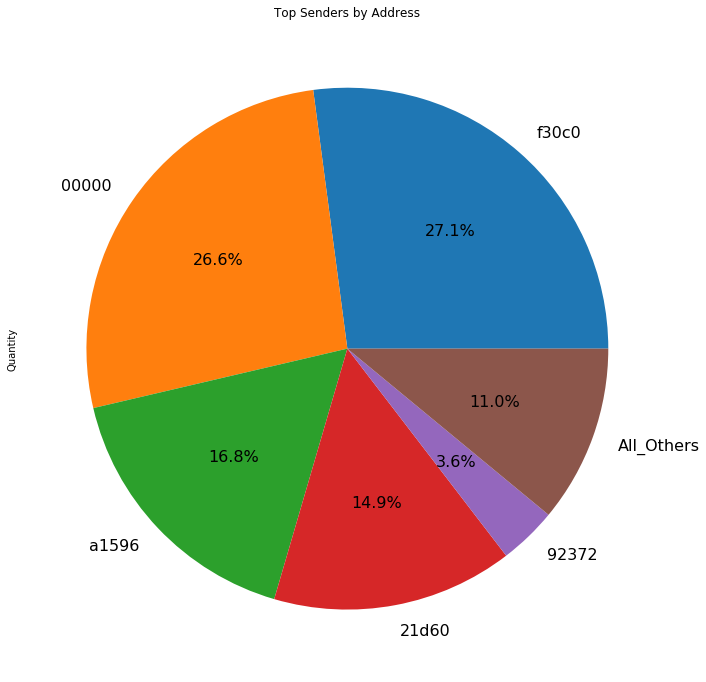

In [40]:
# Plot data in pie chart

etherscan_data_senders.plot.pie(y='Quantity', figsize=(25,12),title='Top Senders by Address',fontsize=16,autopct='%1.1f%%',legend = False)

# Out-of-Sample Performance - Stock Price

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [41]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
stock_mse = mean_squared_error(
    stock_results['Stock Return'],
    stock_results['Predicted Stock Return']
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
stock_rmse = np.sqrt(stock_mse)
print(f"Out of Sample Root Mean Squared Error(RMSE: {stock_rmse}")

Out of Sample Root Mean Squared Error(RMSE: 28.8747457293497


# In-Sample Performance - Stock Price

Evaluate the model using in-sample data (X_train and y_train)

In [42]:
# Construct a dataframe using just the "y" training data:
stock_in_sample_results = stock_y_train

# Add a column of "in-sample" predictions to that dataframe:  
stock_in_sample_results['In-Sample Predictions'] = stock_model.predict(stock_x_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
stock_mse = mean_squared_error(
    stock_in_sample_results['Stock Return'],
    stock_in_sample_results['In-Sample Predictions']
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
stock_rmse = np.sqrt(stock_mse)
print(f'In-sample Root Mean Squared Error (RMSE): {stock_rmse}')

In-sample Root Mean Squared Error (RMSE): 6.753268408471047


# Out-of-Sample Performance - Coin Price

Evaluate the model using in-sample data (X_train and y_train)

In [43]:
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
coin_mse = mean_squared_error(
    coin_results['Coin Return'],
    coin_results['Predicted Coin Return']
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
coin_rmse = np.sqrt(coin_mse)
print(f"Out of Sample Root Mean Squared Error(RMSE: {coin_rmse}")

Out of Sample Root Mean Squared Error(RMSE: 175.9727454501411


# In-Sample Performance - Coin Price

Evaluate the model using in-sample data (X_train and y_train)

In [44]:
# Construct a dataframe using just the "y" training data:
coin_in_sample_results = coin_y_train

# Add a column of "in-sample" predictions to that dataframe:  
coin_in_sample_results['In-Sample Predictions'] = coin_model.predict(coin_x_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
coin_mse = mean_squared_error(
    coin_in_sample_results['Coin Return'],
    coin_in_sample_results['In-Sample Predictions']
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
coin_rmse = np.sqrt(coin_mse)
print(f'In-sample Root Mean Squared Error (RMSE): {coin_rmse}')

In-sample Root Mean Squared Error (RMSE): 8.253122181527436


The model produced a root mean squared error of approximately 0.42 and .60 on the out of sample data and the in sample data respectively. This tells us that the model is performing approximately 30% more accurately on data that it has not seen before.